In [1]:
%matplotlib inline
import os
import time
# os.environ['THEANO_FLAGS']='contexts=dev0->cuda0;dev1->cuda1'
os.environ['THEANO_FLAGS']='device=gpu0'
import theano
import lasagne
import numpy as np
import cPickle as pickle
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits as load_sk_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from helpers.DiscreteLayer import DiscreteLayer

Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5005)


# Breast Cancer dataset cl
* 30 Dimensions of Features
* 2 Classes
* 569 examples (212(M),357(B))

I'll be using ML.Perceptron, for classification

In [2]:
# Constants
NUM_EPOCHS = 500
BATCH_SIZE = 10
LEARNING_RATE = 0.001

# Disc. Layer Settings
DISC = True
QUANT_UNIT = 5
QUANT = np.array(np.repeat(0.125, QUANT_UNIT), dtype='float32')
VARIANCE_DEVIDER = 50000.0
ADDITIONAL_COST = False
# Uniform Settings
UNIFORM_QUANT = True
UNIFORM_STEP = 100

# Test Specs
TEST_NAME = 'digits-quniform100'

# Additional Settings
lasagne.random.set_rng(np.random.RandomState(12345))  # Set random state so we can investigate results
np.random.seed(1234)
#theano.config.exception_verbosity = 'high'

In [3]:
def load_dataset():
    dataset = load_sk_dataset()
    X = dataset['data']
    no_classes = len(np.unique(dataset['target']))
    X = normalize(X, norm='l2')
    #     X = (X - X.mean()) / X.std()
    Y = dataset['target']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
    return dict(X_train=X_train,
               y_train=y_train,
               X_test=X_test,
               y_test=y_test,
               classes=no_classes)
data = load_dataset()
NUM_CLASSES = data['classes']

In [4]:
def build_mlp(Xs, disc, classnum, QUANT_UNIT):
    tanh = lasagne.nonlinearities.tanh
    softmax = lasagne.nonlinearities.softmax
    
    l_in = InputLayer(shape=Xs.shape)
    l_dense1 = DenseLayer(l_in, num_units=25, nonlinearity=tanh)
    l_dense2 = DenseLayer(l_dense1, num_units=QUANT_UNIT, nonlinearity=tanh, name='param_regressor')
    if disc:
        sharedBins = theano.shared(None, name='sharedBins')
        l_dis = DiscreteLayer(l_dense2, sharedBins=sharedBins, name='disclayer')
        print("Using Discret. Layer")
    else:
        l_dis = l_dense2
        print("No Disc. Layer")
    l_class = DenseLayer(l_dis, num_units=classnum, nonlinearity=softmax)
    
    if disc:
        return l_class, sharedBins
    else:
        return l_class

if DISC:
    model, sharedBins = build_mlp(data['X_train'], disc=DISC, classnum=NUM_CLASSES, QUANT_UNIT=QUANT_UNIT)
else:
    model = build_mlp(data['X_train'], disc=DISC, classnum=NUM_CLASSES, QUANT_UNIT=QUANT_UNIT)
model_params = lasagne.layers.get_all_params(model, trainable=True)

Using Discret. Layer


In [5]:
"""
Input: dist, dist.shape = (-1, num_units)
Find quantization bins of a given dist history
Returns a list of (x, num_units), where x's length is a random variable
"""
def find_quantization_bins(dist, sharedBins):
    # Quantizer function
    def Q(x, y):
        return y * np.floor((x/y) + .5)
    
    shape = dist.shape
    init_Q = QUANT
    final_Q = []
    
    # If Uniform Quantization
    if UNIFORM_QUANT:
        uniform_bin = np.linspace(-1, 1, UNIFORM_STEP)
        uniform_bins = np.tile(uniform_bin, (shape[0], 1))
        sharedBins.set_value(uniform_bins)
        print "Uniform Quantization"
        return uniform_bins
    
    # Theta iterator
    for i in range(shape[1]):
        theta_i = dist[:, i]
        
        # Whats is the error threshold for this distribution
        Q_eps = np.var(theta_i) / VARIANCE_DEVIDER
        
        # Batch Iterator
        final_Q_i = []
        for j in range(shape[0]):
            theta = theta_i[j]
            
            # Quantized theta = Quantization bins
            q = init_Q[i]
            x_i = theta
            x_o = Q(x_i, q)
            
            # Optimize x_o

            while(np.abs(x_o - x_i) > Q_eps):
                q = q / 2
                x_o = Q(x_i, q)
            
            # End of optimisation
            final_Q_i.append(x_o)
        
        # Append to outer list
        uniques = np.unique(np.array(final_Q_i))
        final_Q.append(uniques.astype(theano.config.floatX))
        
    # Report
    print "New Bin Sizes: [" + ", ".join([str(final_Q[x].shape[0]) for x in range(shape[1])] ) + "]"
    sharedBins.set_value(final_Q)
    return final_Q

In [6]:
def build_functions():
    X = T.matrix(dtype=theano.config.floatX)
    y = T.ivector()

    ## Layer History
    if DISC:
        l_disc = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'disclayer')
        l_paramreg = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'param_regressor')
        l_disc_output, l_paramreg_output = lasagne.layers.get_output([l_disc, l_paramreg], X, deterministic=False)
    ## Layer History

    # training output
    output_train = lasagne.layers.get_output(model, X, deterministic=False)

    # evaluation output. Also includes output of transform for plotting
    output_eval = lasagne.layers.get_output(model, X, deterministic=True)

    sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
    cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
    
    if ADDITIONAL_COST and DISC:
        cost += T.mean(lasagne.objectives.squared_error(l_disc_output, l_paramreg_output))
    
    updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)
    
    # updates = lasagne.updates.nesterov_momentum(cost, model_params, learning_rate=0.01, momentum=0.9)

    if DISC:
        train = theano.function([X, y], [cost, output_train, l_disc_output, l_paramreg_output], updates=updates, allow_input_downcast=True)
    else:
        train = theano.function([X, y], [cost, output_train], updates=updates, allow_input_downcast=True)
    eval = theano.function([X], [output_eval], allow_input_downcast=True)
    
    return train, eval, sh_lr

train, eval, sh_lr = build_functions()

In [7]:
def train_epoch(X, y):
    # History Keeping
    param_output = []
    disc_output = []
    # History
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        if DISC:
            cost, output_train, l_disc_output, l_paramreg_output = train(X_batch, y_batch)
            param_output = np.append(param_output, l_paramreg_output)
            disc_output = np.append(disc_output, l_disc_output)
        else:
            cost, output_train = train(X_batch, y_batch)
        costs += [cost]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    
    return np.mean(costs), correct / float(num_samples), param_output, disc_output


def eval_epoch(X, y):
    output_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc

In [8]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}, suppress=True)
train_accs, test_accs = [], []
total_time = 0
param_outputs, disc_outputs = [], []
disc_dist_t_1 = None
quantized_bins = []
try:
    for n in range(NUM_EPOCHS):
        start_time = time.time()
        train_cost, train_acc, param_output, disc_output = train_epoch(data['X_train'], data['y_train'])
        test_acc = eval_epoch(data['X_test'], data['y_test'])
        test_accs += [test_acc]
        train_accs += [train_acc]

        if DISC:
            param_outputs = np.append(param_outputs, param_output)
            disc_outputs = np.append(disc_outputs, disc_output)

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.90
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
        
        # Non-uniform Quantization
        if DISC:
            if n>0 and np.mod(n, 10) == 0:
                dist = disc_output.reshape((-1, QUANT_UNIT))
                q_bins = find_quantization_bins(dist, sharedBins=sharedBins)
                quantized_bins.append(q_bins)

        time_spent = time.time() - start_time
        total_time += time_spent
        print "Epoch {0}: T.cost {1:0.6f}, Train acc {2:0.6f}, test acc {3:0.6f}, took {4:.3} sec.".format(
                n, train_cost, train_acc, test_acc, time_spent)

except KeyboardInterrupt:
    pass
print "\nTotal time spent: {0:.5} seconds\nTraing Acc: {1}\nTest Acc: {2}\n".format(total_time, train_acc, test_acc) 

if DISC:
    story = {'train_accs': train_accs,
             'test_accs': test_accs,
             'epoch_reached': n, 
             'total_time': total_time,
             'disc_enabled': DISC,
             'learning_rate': LEARNING_RATE,
             'batch_size': BATCH_SIZE,
             'dense_params': param_output,
             'disc_params': disc_output,
             'quantized_bins': quantized_bins}
else:
    story = {'train_accs': train_accs,
             'test_accs': test_accs,
             'epoch_reached': n, 
             'total_time': total_time,
             'disc_enabled': DISC,
             'learning_rate': LEARNING_RATE,
             'batch_size': BATCH_SIZE,
             'disc_params': disc_output}   

with open(TEST_NAME + '.model', 'wb') as fp:
  pickle.dump(story, fp)

Epoch 0: T.cost 2.193990, Train acc 0.265136, test acc 0.402778, took 0.109 sec.
Epoch 1: T.cost 1.905052, Train acc 0.463466, test acc 0.472222, took 0.119 sec.
Epoch 2: T.cost 1.581611, Train acc 0.543493, test acc 0.575000, took 0.0955 sec.
Epoch 3: T.cost 1.344940, Train acc 0.620042, test acc 0.644444, took 0.0949 sec.
Epoch 4: T.cost 1.187123, Train acc 0.654141, test acc 0.663889, took 0.0946 sec.
Epoch 5: T.cost 1.073210, Train acc 0.672930, test acc 0.672222, took 0.0956 sec.
Epoch 6: T.cost 0.983326, Train acc 0.703549, test acc 0.700000, took 0.0942 sec.
Epoch 7: T.cost 0.908940, Train acc 0.736952, test acc 0.722222, took 0.0922 sec.
Epoch 8: T.cost 0.845830, Train acc 0.768267, test acc 0.744444, took 0.0803 sec.
Epoch 9: T.cost 0.791274, Train acc 0.789840, test acc 0.769444, took 0.0798 sec.
Uniform Quantization
Epoch 10: T.cost 0.743539, Train acc 0.798887, test acc 0.780556, took 0.0894 sec.


helpers/Quantizer.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if sharedBins == None:


Epoch 11: T.cost 0.701392, Train acc 0.814892, test acc 0.783333, took 0.257 sec.
Epoch 12: T.cost 0.664113, Train acc 0.828114, test acc 0.791667, took 0.204 sec.
Epoch 13: T.cost 0.631631, Train acc 0.833681, test acc 0.813889, took 0.206 sec.
Epoch 14: T.cost 0.602576, Train acc 0.840640, test acc 0.819444, took 0.209 sec.
Epoch 15: T.cost 0.575929, Train acc 0.846207, test acc 0.819444, took 0.28 sec.
Epoch 16: T.cost 0.551223, Train acc 0.853862, test acc 0.836111, took 0.275 sec.
Epoch 17: T.cost 0.528613, Train acc 0.860125, test acc 0.844444, took 0.285 sec.
Epoch 18: T.cost 0.506955, Train acc 0.867780, test acc 0.855556, took 0.26 sec.
New LR: 0.000900000042748
Epoch 19: T.cost 0.485950, Train acc 0.869868, test acc 0.872222, took 0.287 sec.
Uniform Quantization
Epoch 20: T.cost 0.466904, Train acc 0.878914, test acc 0.880556, took 0.274 sec.
Epoch 21: T.cost 0.448734, Train acc 0.882394, test acc 0.880556, took 0.304 sec.
Epoch 22: T.cost 0.431597, Train acc 0.890049, test a

# HISTOGRAM

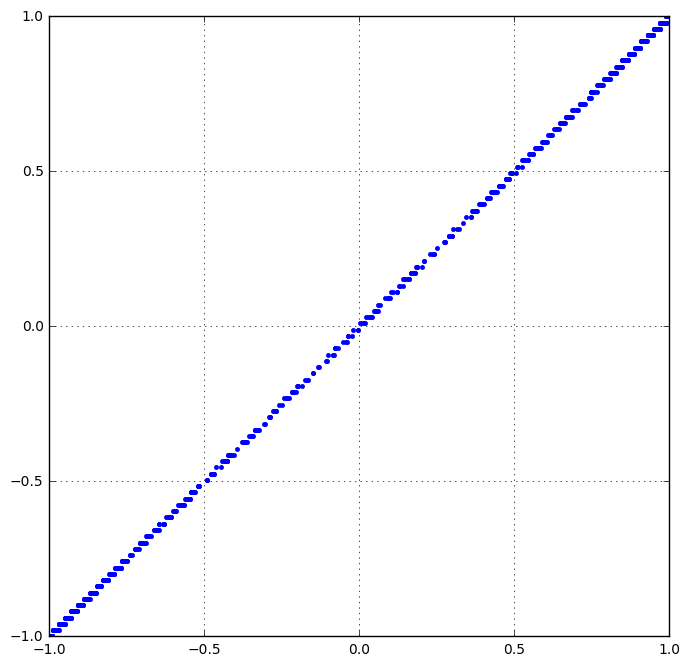

In [25]:
disc_output_r = disc_output.reshape((-1, QUANT_UNIT))
dense_output_r = param_output.reshape((-1, QUANT_UNIT))

plt.switch_backend('Qt5Agg')
plt.figure(figsize=(8,8))
plt.grid(True)
plt.plot(dense_output_r[:, 4], disc_output_r[:, 4], '.')

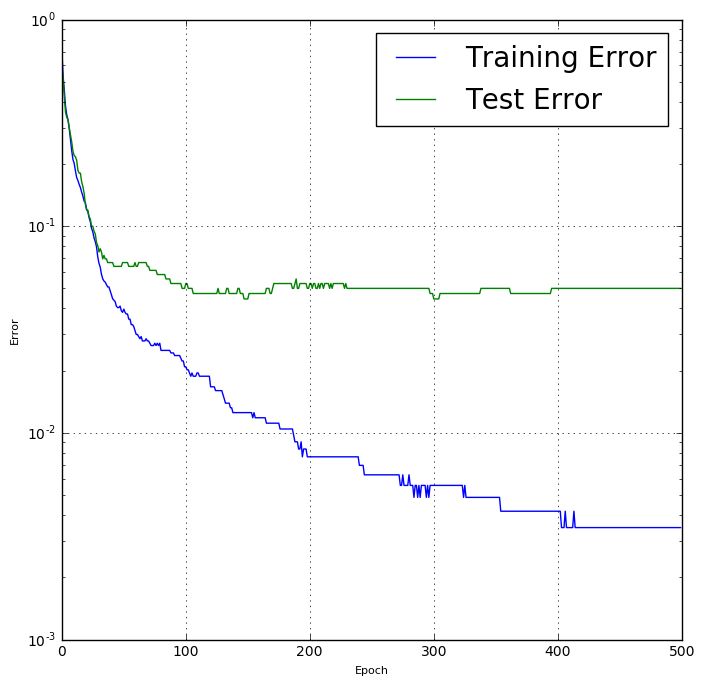

In [26]:
plt.figure(figsize=(8,8))
plt.semilogy(1-np.array(train_accs), label='Training Error')
plt.semilogy(1-np.array(test_accs), label='Test Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Error', fontsize=8)
plt.grid(True)
plt.show()